**В этом ноутбуке представлено построение и обучение сверточной нейронной сети для классификации цифр на изображениях из датасета MNIST**

Импортируем библиотеки

In [1]:
import torch
import torchvision

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import v2

from tqdm import tqdm

import os
import matplotlib.pyplot as plt

from PIL import Image

import sys

from os import path

from torch import nn

Загружаем  датасет MNIST из библиотеки PyTorch

In [ ]:
train_data = torchvision.datasets.MNIST(root='dataset', train=True, download=True)
test_data = torchvision.datasets.MNIST(root='dataset', train=False, download=True)

Распаковываем датасет и размещаем на диске следующим образом:

Папки `train` и `test`, находящиеся по адресу `dataset/MNIST/images`, содержат тренеровочную и тестувую выборку соответственно. В них картинки распределены по папкам, название которых это цыфра, изображения которой находятся в этой папке

In [ ]:
# функция, которая распаковывает бинарник с датасетом и сохраняет картинки по указанному пути
def convert_to_jpg(dataset, output_folder):
	'''
	dataset - объект выборки
	output_folder - путь, по которому сохраняется выборка
	'''

	for i, (image, label) in enumerate(dataset):

		save_folder = os.path.join(output_folder, str(label))

		if not os.path.exists(save_folder):
			os.makedirs(save_folder)

		image.save(os.path.join(save_folder, f'{i}.jpg'))

convert_to_jpg(train_data, "dataset/MNIST/images/train")
convert_to_jpg(test_data, "dataset/MNIST/images/test")

Описываем свой класс датасета MNIST

In [ ]:
class MNISTDataSet(Dataset):


	# конструктор класса
	def __init__(self, path: str, transform: v2.Compose=None):
		'''
		path - путь к папке с выборкой
		transform - объект трансформации изображения
		'''

		self.path = path
		self.transform = transform

		self.len_dataset = 0    # размер выборки
		self.data_list = []     # список пар (путь к картинке, класс картинки)

		# перебираем папки и файлы по указанному пути
		for path_dir, dir_list, file_list in os.walk(path):

			# если сейчас находимся в папке path, записываем названия папок в классы
			if path_dir == path:
				self.classes = dir_list
				self.clas_to_idx = {
					cls_name: i for i, cls_name in enumerate(self.classes)
				}
				continue

			cls = path_dir.split('/')[-1]

			# добавляем картинку и ее класс в data_list
			for name_file in file_list:
				file_path = os.path.join(path_dir, name_file)
				self.data_list.append((file_path, self.clas_to_idx[cls]))

			self.len_dataset += len(file_list)


	# метод олучения длины
	def __len__(self):
		return self.len_dataset


	# метод обращения по индексу
	def __getitem__(self, index: int):
		'''
		index - индекс семпла датасета
		'''

		# открываем картинку
		file_path, target = self.data_list[index]
		sample = Image.open(file_path)

		# применяем трансформацию, если необходимо
		if self.transform:
			sample = self.transform(sample)

		return sample, target

Создаем объект транформации изображения.
В нем мы превращаем изображение в матрицу, значения в которых - это яркость пикселя, переводим значения в `float32` и приводим к распределению со средним 0.5 и стандартным отклонением 0.5

In [ ]:
transform = v2.Compose(
	[
		v2.ToTensor(),
		v2.ToDtype(torch.float32, scale=True),
		v2.Normalize(mean=(0.5,), std=(0.5,))
	]
)

Переводим классы `train_data` и `test_data` в наш `MNISTDataSet`

In [ ]:
path = "/dataset/MNIST/images/"

path = "/content" + path    # добавка к пути для колаба

train_data = MNISTDataSet(path + "train", transform=transform)
test_data = MNISTDataSet(path + "train", transform=transform)

Проверяем размер тренеровочной выборки и пробуем нарисовать одну из цифр

In [59]:
len(train_data)

60000

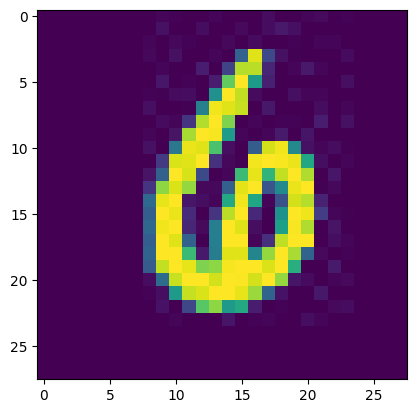

In [34]:
plt.imshow(train_data[40000][0][0])

Теперь создаем загрузчики батчей для тренеровочной и тестовой выборок, не забываем перемешывать тренеровочную выборку

In [35]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

В переменную device сохраняем `"cuda"`, если возможно обучение на GPU, иначе сохраняем `"cpu"`

In [36]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

Объявляем класс сверточной нейронной сети с методами для обучения и предсказания

In [ ]:
class MNISTModel(nn.Module):

	# конструктор
	def __init__(self):
		super().__init__()

		# устройство, на котором находятся веса модели
		self.device = "cpu"

		# сверточная часть модели
		# 4 сверточных слоя с Batchnorm и relu в качестве функций активации
		# Для понижения размерности используется maxpool
		self.conv = nn.Sequential(
		   nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
		   nn.BatchNorm2d(32),
		   nn.ReLU(),

		   nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
		   nn.BatchNorm2d(32),
		   nn.ReLU(),

		   nn.MaxPool2d(kernel_size=2, stride=2),

		   nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
		   nn.BatchNorm2d(64),
		   nn.ReLU(),

		   nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
		   nn.BatchNorm2d(64),
		   nn.ReLU(),

		   nn.MaxPool2d(kernel_size=2, stride=2)
		)

		# Полносвязная часть сети
		# 2 скрытых слоя с batchnorm и dropout, функция активации relu
		self.dence = nn.Sequential(
			nn.Dropout(0.5),
			nn.Linear(64 * 7 * 7, 512),
			nn.BatchNorm1d(512),
			nn.ReLU(),

			nn.Dropout(0.5),
			nn.Linear(512, 512),
			nn.BatchNorm1d(512),
			nn.ReLU(),

			nn.Dropout(0.5),
			nn.Linear(512, 10),
		)

		self.loss = nn.CrossEntropyLoss()
		self.softmax = nn.Softmax(dim=1)


	# переопределяем метод to родительского класса для сохранения устроиства
	def to(self, device: str):
		'''
		переместить веса модели на устройство device
		'''
		self.device = device
		return super().to(device)


	# прямой проход
	def forward(self, x):

		x = self.conv(x)
		x = x.view(x.size(0), -1)
		x = self.dence(x)

		return self.softmax(x)

	def fit(self, train: DataLoader, val: DataLoader, epochs: int):
		'''
		метод обучения модели

		train - тренеровочная выборка
		val - валидационная выборка
		epochs - количество эпох

		возвращает картеж следующего содержания:

		массив лоссов на тренеровочной выборке по эпохам
		массив лоссов на валидационной выборке по эпохам
		массив accuracy на тренеровочной выборке по эпохам
		массив accuracy на валидационной выборке по эпохам
		'''

		# оптимизируем лосс алгоритмом adam
		opt = torch.optim.Adam(self.parameters(), lr=0.001)

		train_acc = []    # массив accuracy на тренеровочной выборке по эпохам
		val_acc = []      # массив accuracy на валидационной выборке по эпохам

		train_loss = []   # массив лоссов на тренеровочной выборке по эпохам
		val_loss = []     # массив лоссов на валидационной выборке по эпохам

		best_acc = 0      # лучший accuracy на валидационной выборке

		for epoch in range(epochs):

			# сначала обучаем модель

			# переводим модель в режим обучения
			self.train()

			train_loop = tqdm(train, leave=False)

			cur_acc = 0
			train_loss_list = []

			# достаем батчи из загрузчика
			for x, targets in train_loop:

				# переводим тензоры объектов и классов на устройство
				x = x.to(self.device)
				targets = targets.to(self.device)

				# делаем прямой проход и считаем лосс
				pred = self(x)
				loss = self.loss(pred, targets)
				train_loss_list.append(loss.item())

				# корректируем веса
				opt.zero_grad()
				loss.backward()
				opt.step()

				# считаем accuracy на данном батче
				cur_acc += (torch.max(pred.data, 1)[1] == targets).sum().item()
				mean_train_loss = sum(train_loss_list) / len(train_loss_list)

				# обновляем инфу в консоли
				train_loop.set_description(f'Epoch {epoch + 1}/{epochs}, train_loss {mean_train_loss:.4f}')

			# считаем средний лосс и accuracy на этой эпохе для тренеровочной выборки
			train_acc.append(cur_acc / (len(train) * train.batch_size))
			train_loss.append(mean_train_loss)

			# теперь валидируем модель на этой эпохе

			# переводим модель в режим валидации
			self.eval()
			with torch.no_grad():

				cur_acc = 0
				val_loss_list = []

				# достаем батчи из загрузчика
				for x, targets in val:

					# переводим тензоры объектов и классов на устройство
					x = x.to(self.device)
					targets = targets.to(self.device)

					# делаем прямой проход и считаем лосс
					pred = self(x)
					loss = self.loss(pred, targets)

					val_loss_list.append(loss.item())

					# считаем accuracy на данном батче
					cur_acc += (torch.max(pred.data, 1)[1] == targets).sum().item()
					mean_val_loss = sum(val_loss_list) / len(val_loss_list)

			# считаем средний лосс и accuracy на этой эпохе для валидационной выборки
			val_loss.append(mean_val_loss)
			val_acc.append(cur_acc / (len(val) * val.batch_size))

			# если accuracy на валидации оказался больше, чем максимальный до этого, сохраняем веса
			if val_acc[-1] > best_acc:
				torch.save(self.state_dict(), f"model_acc_{val_acc[-1]:.3f}".replace(".", "") + ".pt")
				best_acc = val_acc[-1]

			# печатаем текущие значения среднего лосса и accuracy
			print(f'Epoch {epoch + 1}/{epochs}, train loss {train_loss[-1]:.4f}, val loss {val_loss[-1]:.4f}, train accuracy {train_acc[-1]:.4f}, val accuracy {val_acc[-1]:.4f}')

		return train_loss, val_loss, train_acc, val_acc


	def predict_proba(self, paths, transform: v2.Compose = None):
		'''
		метод предсказания вероятностей пренадлежнойсти к классу

		paths - массив путей к файлам картинок
		transform - объект трансформации картинок
		'''

		# открываем картинки по указанным путям
		imgs = [Image.open(path) for path in paths]

		# если трансформация не задана, ставим ее по умолчанию
		if not transform:
			transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

		# делаем трансформацию, переводим list в tensor и перемещаем на устройство
		imgs = torch.stack(list(map(transform, imgs))).to(self.device)

    	# делаем прямой проход
		self.eval()
		with torch.no_grad():
			res = self(imgs).detach()

		return res


	def predict(self, paths, transform = None):
		'''
		метод предсказания класса

		paths - массив путей к файлам картинок
		transform - объект трансформации картинок
		'''

		return torch.argmax(self.predict_proba(paths, transform), dim=1)


Создаем и обучаем модель

In [74]:
model = MNISTModel().to(device)

In [75]:
train_loss, val_loss, train_acc, val_acc = model.fit(train_loader, test_loader, 5)

Epoch 1/5, train loss 1.5367, val loss 1.4784, train accuracy 0.9313, val accuracy 0.9832


Epoch 2/5, train loss 1.5021, val loss 1.4752, train accuracy 0.9600, val accuracy 0.9861


Epoch 3/5, train loss 1.4954, val loss 1.4739, train accuracy 0.9662, val accuracy 0.9874


Epoch 4/5, train loss 1.4912, val loss 1.4718, train accuracy 0.9702, val accuracy 0.9893


Epoch 5/5, train loss 1.4886, val loss 1.4714, train accuracy 0.9728, val accuracy 0.9898


Точность модели на тестовой выборке достигла 0.99!

Пробуем определить число на картинке

Возьмем картинку из тестовой выборки

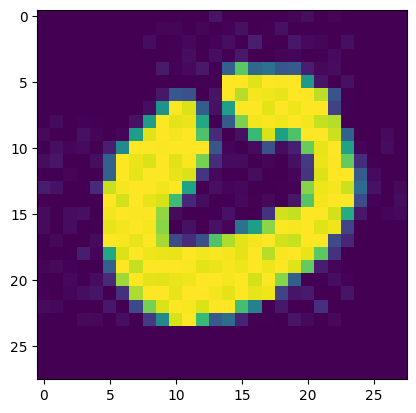

In [77]:
img_path = "dataset/MNIST/images/test/0/25.jpg"

plt.imshow(Image.open(img_path))

Предскажем для нее класс

In [78]:
model.predict([img_path], transform)

tensor([0], device='cuda:0')

Сохраняем веса модели

In [ ]:
torch.save(model.state_dict(), "model.pt")